# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble      import RandomForestRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# TabNet library
#
from pytorch_tabnet.tab_model import TabNetRegressor


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Data handling parameters

In [3]:
# Parameters
#
filename   = 'metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [4]:
Lag        =   12
Horizon    =   6

# Data handling

## Import data


In [5]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.43 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO,NH4
0,2022-01-27 16:12:40,26.5,17.0,0.5,0.5,75.0,298.0,NaN
1,2022-01-27 16:12:56,26.7,17.0,0.5,0.5,75.0,298.0,NaN
2,2022-01-27 16:13:13,26.8,17.0,0.5,0.5,76.0,298.0,NaN


## Preprocess data

### Set index

In [6]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-01-27 16:10:00,0.477778
2022-01-27 16:15:00,0.463158
2022-01-27 16:20:00,0.715789


In [7]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [8]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

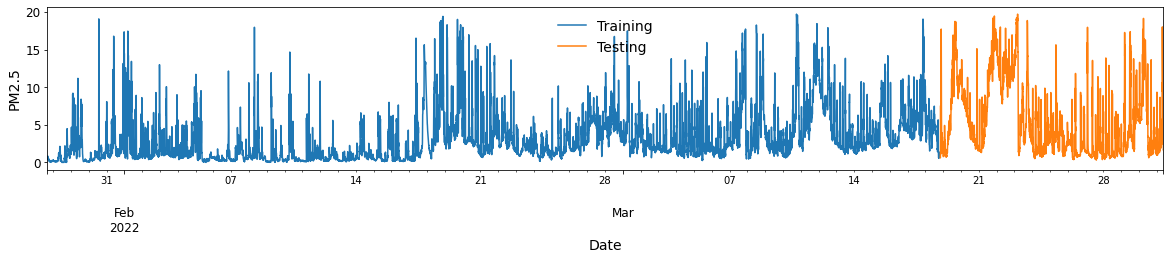

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train.plot(ax=ax, color='tab:blue' )
df_test.plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [10]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [11]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = max(df.min().min(), 1.0)
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  
    
VALUE

[INFO] Data transformation applied


1.0

In [12]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )    

[INFO] Scaling: Standard


## Create Training/Testing data

In [13]:
def create_dataset(df, look_back=1, Horizon = 1, SeriesName ='', overlap = 1):
    
    # Check if SeriesName exists in dataset
    #
    if (SeriesName not in df.columns):
        SeriesName = df.columns[-1]
    
    
    date, dataX, dataY = [], [], []

    for i in tqdm( range(0, df.shape[0] + 1  - look_back - Horizon, overlap) ):
                    
        
        data = df[i:(i+look_back+Horizon)].copy()
        # Not sequental interval
        #
        if (data.reset_index().diff()[1:].nunique()['Date'] > 1): continue
         
        # X
        #
        # Lag-Instances from Target Series
#         A = data[ SeriesName ].to_numpy()[:look_back].flatten()        
#         # Information from other features (only from current time)
#         B = data.iloc[look_back-1, data.columns != SeriesName].to_numpy()
#         # Concatenate all information - Instance created
#         dataX.append( np.concatenate([A, B]) )
        
#         dataX.append( data[ SeriesName ].to_numpy()[:look_back].flatten() )



        A = data[ SeriesName ].to_numpy()[:look_back].flatten()        
        # Information from Moving-Average features
        B = np.array([
                       data[:look_back][ SeriesName ].to_numpy()[-4:].mean(),
                       data[:look_back][ SeriesName ].to_numpy()[-7:].mean(),
                       data[:look_back][ SeriesName ].to_numpy().mean(),     
                       #
                       data[:look_back][ SeriesName ].to_numpy()[-4:].std(),
                       data[:look_back][ SeriesName ].to_numpy()[-7:].std(),    
                       #
                       np.sin( data.index.hour[look_back] + data.index.minute[look_back] / 60.0 ),
                       np.cos( data.index.hour[look_back] + data.index.minute[look_back] / 60.0 )
                      ])
        # Concatenate all information - Instance created
        dataX.append( np.concatenate([A, B]) )



        # ALL DATA: dataX.append( data.to_numpy()[:look_back].flatten() )


        # Y
        #
        dataY.append( data[ SeriesName ].to_numpy()[ look_back : look_back + Horizon] )
        
        # Date (ahead) - Needed for visualization
        #
        date.append( data.index[ look_back : look_back + Horizon] )
                      
    return ( np.array(dataX), np.array(dataY), np.array(date) )

In [14]:
trainX, trainY, _ = create_dataset(df           = df_train, 
                                   look_back    = Lag, 
                                   Horizon      = Horizon, 
                                   SeriesName   = targetSeries,
                                   overlap      = Horizon,
                                   )

testX,  testY, _  = create_dataset(df           = df_test, 
                                   look_back    = Lag, 
                                   Horizon      = Horizon, 
                                   SeriesName   = targetSeries,
                                   overlap      = 1,)



print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 3607/3607 [00:13<00:00, 266.00it/s]

Training instances:     2406
Testing instances:      3607


# Forecasting model: TabNet

## Setup model

In [15]:
model = TabNetRegressor(verbose = 1, 
                        seed    = 42)

Device used : cpu


## Training process

In [17]:
import torch.nn as nn

# Start clock
#
start = time.time()

# Train model
#
model.fit(X_train = trainX, 
          y_train = trainY,
          loss_fn = nn.MSELoss(), # nn.L1Loss(), nn.MSELoss()
          #
          eval_set    = [(testX, testY)],
          batch_size  = 32,
          num_workers = 0,
          patience    = 300, 
          max_epochs  = 2000,
          eval_metric = ['rmse'])

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

epoch 0  | loss: 0.70307 | val_0_rmse: 0.67481 |  0:00:01s
epoch 1  | loss: 0.34535 | val_0_rmse: 0.62141 |  0:00:03s
epoch 2  | loss: 0.33015 | val_0_rmse: 0.56546 |  0:00:05s
epoch 3  | loss: 0.32927 | val_0_rmse: 0.60495 |  0:00:06s
epoch 4  | loss: 0.31318 | val_0_rmse: 0.54442 |  0:00:08s
epoch 5  | loss: 0.30219 | val_0_rmse: 0.54563 |  0:00:10s
epoch 6  | loss: 0.30694 | val_0_rmse: 0.52267 |  0:00:12s
epoch 7  | loss: 0.29723 | val_0_rmse: 0.60633 |  0:00:13s
epoch 8  | loss: 0.3165  | val_0_rmse: 0.69099 |  0:00:15s
epoch 9  | loss: 0.30211 | val_0_rmse: 0.52011 |  0:00:16s
epoch 10 | loss: 0.29107 | val_0_rmse: 0.51008 |  0:00:18s
epoch 11 | loss: 0.28744 | val_0_rmse: 0.5264  |  0:00:19s
epoch 12 | loss: 0.28541 | val_0_rmse: 0.50754 |  0:00:21s
epoch 13 | loss: 0.28271 | val_0_rmse: 0.50977 |  0:00:22s
epoch 14 | loss: 0.2805  | val_0_rmse: 0.49329 |  0:00:24s
epoch 15 | loss: 0.28575 | val_0_rmse: 0.50645 |  0:00:26s
epoch 16 | loss: 0.28279 | val_0_rmse: 0.50386 |  0:00:2

epoch 139| loss: 0.23433 | val_0_rmse: 0.50452 |  0:03:35s
epoch 140| loss: 0.24391 | val_0_rmse: 0.49844 |  0:03:36s
epoch 141| loss: 0.24216 | val_0_rmse: 0.54087 |  0:03:38s
epoch 142| loss: 0.25028 | val_0_rmse: 0.50108 |  0:03:39s
epoch 143| loss: 0.24441 | val_0_rmse: 0.7117  |  0:03:41s
epoch 144| loss: 0.25012 | val_0_rmse: 0.49419 |  0:03:42s
epoch 145| loss: 0.24182 | val_0_rmse: 0.5079  |  0:03:44s
epoch 146| loss: 0.24593 | val_0_rmse: 0.52486 |  0:03:45s
epoch 147| loss: 0.24367 | val_0_rmse: 0.49295 |  0:03:47s
epoch 148| loss: 0.24072 | val_0_rmse: 0.55898 |  0:03:49s
epoch 149| loss: 0.23797 | val_0_rmse: 0.53104 |  0:03:50s
epoch 150| loss: 0.23424 | val_0_rmse: 0.60078 |  0:03:52s
epoch 151| loss: 0.2326  | val_0_rmse: 0.49881 |  0:03:53s
epoch 152| loss: 0.25105 | val_0_rmse: 0.54369 |  0:03:55s
epoch 153| loss: 0.23046 | val_0_rmse: 0.51202 |  0:03:56s
epoch 154| loss: 0.2325  | val_0_rmse: 0.49944 |  0:03:58s
epoch 155| loss: 0.23621 | val_0_rmse: 0.49659 |  0:03:5

epoch 278| loss: 0.22172 | val_0_rmse: 0.53785 |  0:07:07s
epoch 279| loss: 0.21258 | val_0_rmse: 0.64421 |  0:07:09s
epoch 280| loss: 0.21289 | val_0_rmse: 0.53429 |  0:07:10s
epoch 281| loss: 0.21031 | val_0_rmse: 0.6804  |  0:07:12s
epoch 282| loss: 0.22182 | val_0_rmse: 0.52057 |  0:07:13s
epoch 283| loss: 0.22221 | val_0_rmse: 0.50592 |  0:07:15s
epoch 284| loss: 0.22735 | val_0_rmse: 0.52869 |  0:07:16s
epoch 285| loss: 0.21844 | val_0_rmse: 0.50557 |  0:07:18s
epoch 286| loss: 0.21667 | val_0_rmse: 0.51577 |  0:07:19s
epoch 287| loss: 0.22132 | val_0_rmse: 0.5205  |  0:07:21s
epoch 288| loss: 0.22192 | val_0_rmse: 0.52427 |  0:07:22s
epoch 289| loss: 0.2105  | val_0_rmse: 0.53524 |  0:07:24s
epoch 290| loss: 0.21701 | val_0_rmse: 0.53379 |  0:07:25s
epoch 291| loss: 0.22584 | val_0_rmse: 0.50797 |  0:07:27s
epoch 292| loss: 0.21597 | val_0_rmse: 0.51317 |  0:07:28s
epoch 293| loss: 0.21317 | val_0_rmse: 0.56226 |  0:07:30s
epoch 294| loss: 0.22424 | val_0_rmse: 0.49744 |  0:07:3

## Evaluation

### Get predictions

In [18]:
# Get predictions
#
pred = model.predict( testX )


# # Get prediction of each component tree
# #
# predictions = []
# for Tree in model.estimators_:
#     predictions += [ Tree.predict( testX ) ]
    
# predictions = np.array( predictions )

### Apply inverse scaling/transformation

In [19]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [20]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

#     # Present results
#     #
#     print('Horizon: ', i)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.81 SMAPE: 17.31 R2: 0.92
Horizon:  2 MAE  0.96 SMAPE: 22.44 R2: 0.88
Horizon:  3 MAE  1.14 SMAPE: 26.71 R2: 0.84
Horizon:  4 MAE  1.29 SMAPE: 29.87 R2: 0.80
Horizon:  5 MAE  1.49 SMAPE: 33.16 R2: 0.75
Horizon:  6 MAE  1.69 SMAPE: 36.32 R2: 0.69


## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


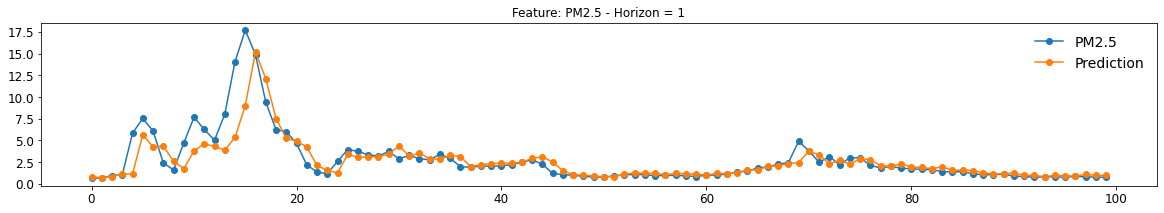

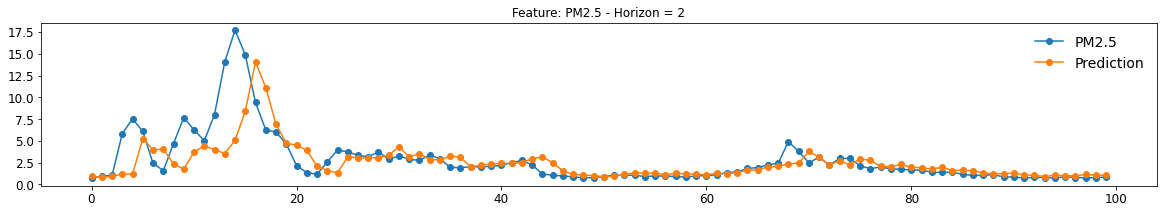

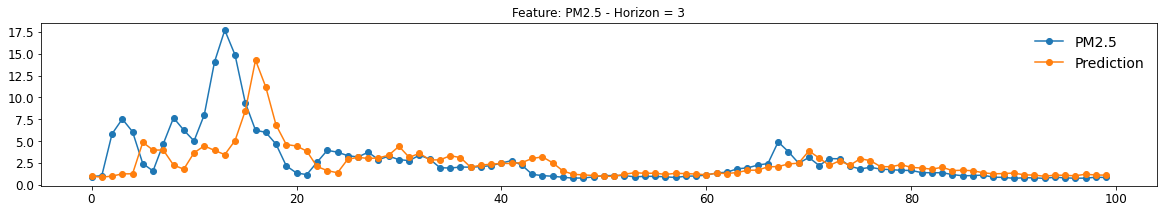

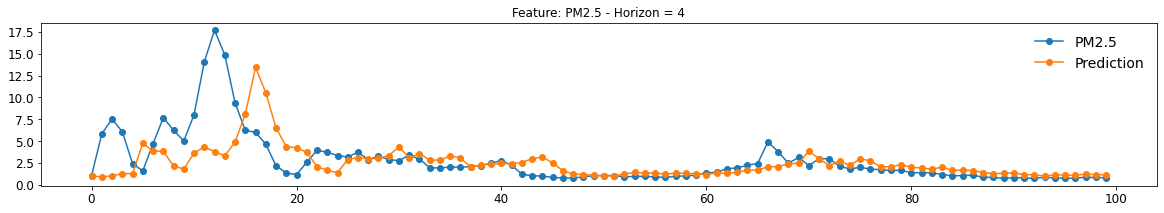

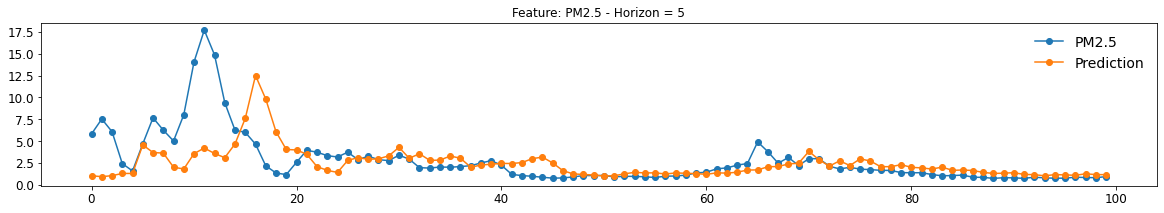

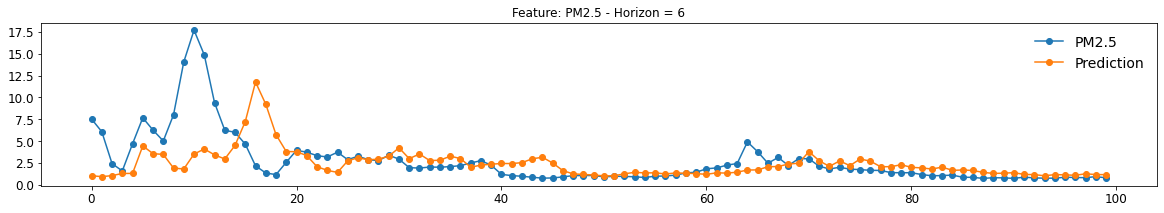

In [21]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Examples

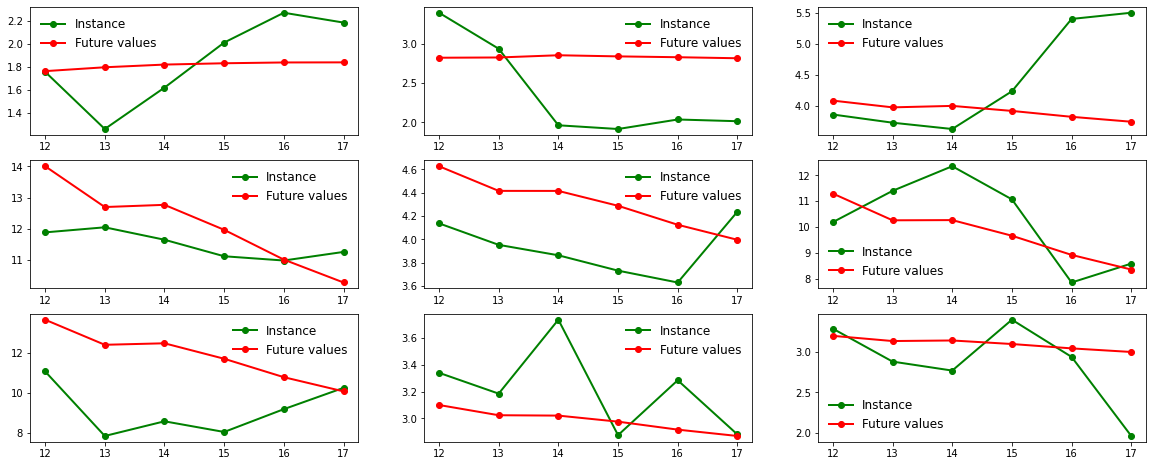

In [22]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [113, 34, 141, 325, 139, 185, 188, 27, 31]


for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

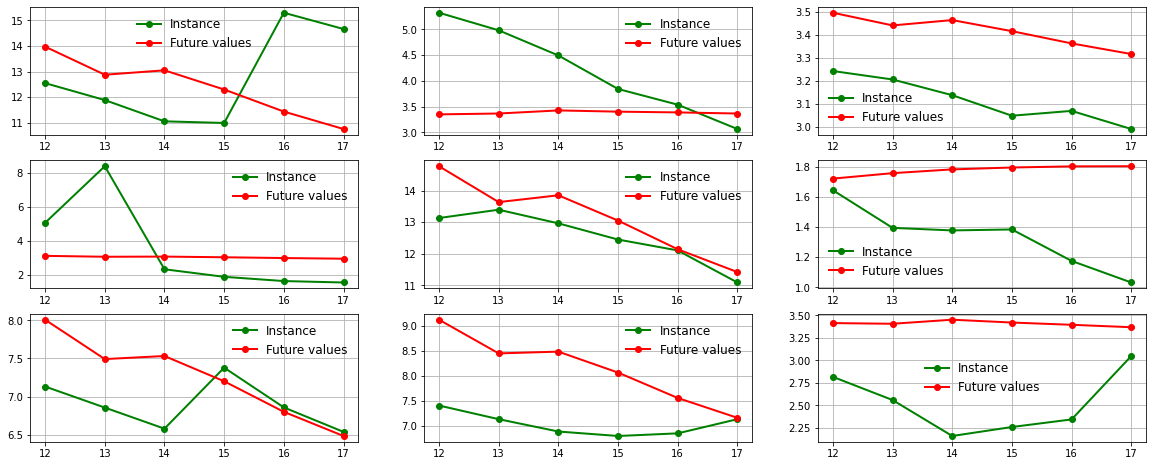

In [23]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
#     plot_scatter(range(0, Lag),             testX[i,:Lag], color='b')
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
#     plt.ylim([0, 8])
plt.show()

# Store errors

In [24]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries] = testY.flatten()
Outputs['TabNet']         = pred.flatten()
#
Outputs.to_csv('Predictions/TabNet.csv')